In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import time
import matplotlib.pyplot as plt


In [2]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

In [4]:
# Hyperparameters etc.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda"
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1  # 784
batch_size = 30
num_epochs = 10

In [5]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]
)

dataset = datasets.MNIST(root="C:\\Users\\mvpco\\Documents\\School stuff\\GAN\\dataset/", transform=transforms, download=False)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")   
writer_real = SummaryWriter(f"logs/real")
step = 0

In [6]:
epoch_time = []

In [7]:
epoch_nums = [x for x in range(num_epochs)]

In [8]:
epoch_time_cuda = []

In [9]:
# Training Loop
for epoch in range(num_epochs):
    start = time.time()
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1
    end = time.time()
    time_taken = round(end - start, 2) # stores the time taken for one epoch to run 
    epoch_time.append(time_taken)
    print(device, time_taken, "seconds per Epoch")

Epoch [0/10] Batch 0/2000                       Loss D: 0.6629, loss G: 0.6600
cuda 20.9 seconds per Epoch
Epoch [1/10] Batch 0/2000                       Loss D: 0.4091, loss G: 1.2159


KeyboardInterrupt: 

NameError: name 'epoch_time_cuda' is not defined

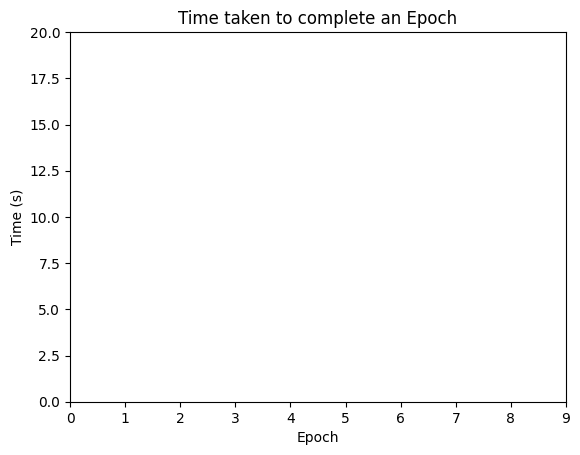

In [10]:
plt.title("Time taken to complete an Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.axis([0, 9, 0, 20])
plt.plot(epoch_nums, epoch_time_cuda, label="GPU - RTX 3050 Ti")
plt.plot(epoch_nums, epoch_time, label="CPU - Ryzen 7 5800H")
plt.legend(loc='lower center')
plt.show()